In [ ]:
#dataset download
!pip install kaggle
!kaggle datasets download -d splcher/animefacedataset
!unzip animefacedataset.zip -d anime_dataset/

In [1]:
import wandb
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils
from PIL import Image
from torch_snippets import *
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/raid/miniconda3/envs/dl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

device = "cuda" if torch.cuda.is_available() else "cpu"

WANDB_CONFIG = {
    '_wandb_kernel': 'neuracort'
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: madhavkataria (madhav-kataria). Use `wandb login --relogin` to force relogin


In [3]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [4]:
class AnimeFaces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(f'{self.folder}/*.jpg'))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image


In [5]:
ds = AnimeFaces(folder='anime_dataset/images')
dataloader = DataLoader(ds, batch_size=256, shuffle=True, num_workers=8)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)

    def forward(self, input):
        return self.model(input).view(-1, 1)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self, input):
        return self.model(input)

In [9]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [10]:
def noise(size):
    return torch.randn(size, 100, 1, 1, device=device)

def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = criterion(prediction_real, torch.ones(len(real_data), 1).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data.detach())
    error_fake = criterion(prediction_fake, torch.zeros(len(fake_data), 1).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = criterion(prediction, torch.ones(len(fake_data), 1).to(device))
    error.backward()
    g_optimizer.step()
    return error


100%|██████████| 50/50 [10:04<00:00, 12.10s/it]


d_loss,▄▄▄▂▂▁▁▂▂▃█▂▂▃▂▄▂▁▂▂▅▂▃▃▆▅▂▅▂▇▂▄▁▁▄▂▁▁▁▄
g_loss,█▃▆▅▅▅▆▄▄▄▅▄▅▅▃▆▄▃▄▃▅▃▂▄▂▄▃▅▃▁▃▂▃▃▅▄▃▃▄▁
d_loss,0.64271
g_loss,0.69358


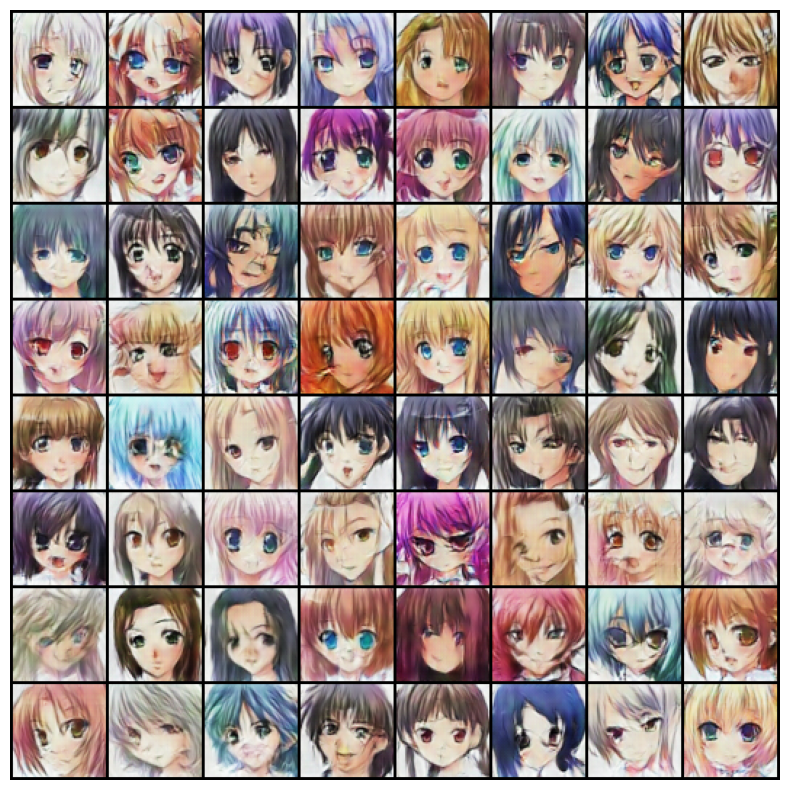

In [11]:
n_epochs = 50
fixed_noise = noise(64)
img_list = []

run = wandb.init(project='CGAN_ANIME', config=WANDB_CONFIG)


for epoch in tqdm(range(n_epochs), total=n_epochs):
    for bx, real_data in enumerate(dataloader):
        real_data = real_data.to(device)
        
        fake_data = generator(noise(len(real_data)))
        d_loss = discriminator_train_step(real_data, fake_data)
        
        fake_data = generator(noise(len(real_data)))
        g_loss = generator_train_step(fake_data)

        wandb.log({
            'd_loss': d_loss.item(),
            'g_loss': g_loss.item()
        })

    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
        imgs = vutils.make_grid(fake, padding=2, normalize=True).permute(1,2,0)
        img_list.append(imgs)
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.imshow(imgs)
        plt.savefig(f"anime_gan_epoch_{epoch}.jpg")
        plt.close()

    wandb.log({
        "Generated Images": wandb.Image(f"anime_gan_epoch_{epoch}.jpg")
    })
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img_list[-1])
plt.savefig("final_anime_gan_predictions.jpg")

table_generated = wandb.Table(columns=['Image'])
table_generated.add_data(wandb.Image("final_anime_gan_predictions.jpg"))
wandb.log({"Final Generated Anime Faces": table_generated})

wandb.finish()

In [13]:
torch.save(generator.state_dict(), 'generator_final.pth')
torch.save(discriminator.state_dict(), 'discriminator_final.pth')


with torch.no_grad():
    fake = generator(fixed_noise).detach().cpu()
    final_grid = vutils.make_grid(fake, padding=2, normalize=True)
    